# Embed, Encode and Predict

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [7]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [8]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

__Note:__ 

Setting the embedding weights and making the layer trainable (so backprop can update the weights) results in much better performance (0.788 accuracy on test set, 0.9831 on training set) than making the layer non-trainable (0.706 accuracy on test set, 0.7827 on training set). One possible reason is that making the embedding layer non-trainable drops the number of trainable parameters from 12,540,970 to 321,970 (about 10x our base embed-predict BoW model with 32,120 parameters).

In [10]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")
sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE))(sent_emb)

sent_encoder = Model(inputs=sent_inputs, outputs=sent_enc)
sent_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           12219000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240600    
Total params: 12,459,600
Trainable params: 12,459,600
Non-trainable params: 0
_________________________________________________________________


In [11]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")
doc_emb = TimeDistributed(sent_encoder)(doc_inputs)
doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE))(doc_emb)

fc1_dropout = Dropout(0.2)(doc_enc)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 60)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 200)           12459600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               75300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
Total para

In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 127s - loss: 2.9953 - acc: 0.0572 - val_loss: 2.9256 - val_acc: 0.0902
Epoch 2/10
11872/11872 [==============================] - 127s - loss: 2.4206 - acc: 0.1880 - val_loss: 1.7549 - val_acc: 0.4205
Epoch 3/10
11872/11872 [==============================] - 127s - loss: 1.5096 - acc: 0.4501 - val_loss: 1.2033 - val_acc: 0.5697
Epoch 4/10
11872/11872 [==============================] - 128s - loss: 0.9024 - acc: 0.6685 - val_loss: 1.0022 - val_acc: 0.6705
Epoch 5/10
11872/11872 [==============================] - 125s - loss: 0.5487 - acc: 0.8038 - val_loss: 1.0231 - val_acc: 0.6970
Epoch 6/10
11872/11872 [==============================] - 127s - loss: 0.3494 - acc: 0.8825 - val_loss: 1.0686 - val_acc: 0.7326
Epoch 7/10
11872/11872 [==============================] - 127s - loss: 0.2280 - acc: 0.9332 - val_loss: 1.1956 - val_acc: 0.7417
Epoch 8/10
11872/11872 [========================

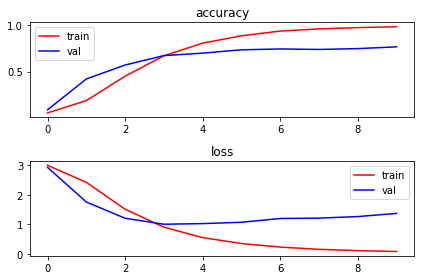

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [15]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.770

confusion matrix

[[183   0   0   0   0   0   0   1   0   1   0   1   0   2   1  12   0   4   3  17]
 [  0 214  28   8   3  11   3   1   0   0   0   4   9   4   9   0   0   0   1   0]
 [  0  38 214  19   6  29   0   4   1   0   0   1   2   1   2   0   0   0   0   2]
 [  0  15  38 204  17   0   8   3   0   0   1   2   6   1   0   0   0   0   0   0]
 [  0   9  22  40 163   2  12  10   1   0   0   0  18   0   0   0   0   0   2   0]
 [  0  17  28   4   2 234   1   0   0   0   0   9   5   0   2   0   0   0   0   0]
 [  0   1   0  33  16   0 188  28   8   2   2   1   5   2   2   1   0   1   0   0]
 [  0   1   0   0   6   0   6 216   8   0   0   0  10   0   7   0   0   0   3   2]
 [  0   0   0   1   1   0   0  21 248   2   0   0   2   0   7   0   2   0  10   0]
 [  1   1   1   0   0   0   2   2  19 273  23   0   0   3   4   0   8   1   3   1]
 [  1   1   1   1   0   0   4   3   1  15 281   0   1   0   0   0   0   0   1   0]
 [  0   9   1   1   1   7   0   2   0   2   0 